In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sqlalchemy import create_engine

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
    
query1='''
SELECT
    *
FROM
    heartdisease
'''
    
    
df = pd.read_sql_query(query1, con=engine)
engine.dispose()

In [1]:
def plot_hist_boxplot(df):
    '''
    Accepts only numerical columns;
    use a maks.
    '''
    dim = df.shape[1]
    plt.figure(figsize=(20, dim*5))
    
    # iterate through the columns
    for i, column in enumerate(df.columns):
        
        # plot a histogram
        plt.subplot(dim, 2, (i+1)*2-1)
        plt.hist(df[column])
        plt.ylabel(column, size='xx-large')
        
        # plot a boxplot
        plt.subplot(dim, 2, (i+1)*2)
        plt.boxplot(df[column], whis=[2.5, 97.5]) # boxplot will show outliers beyond the inner 90th percentile
    plt.show()

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


TypeError: unsupported operand type(s) for /: 'str' and 'int'

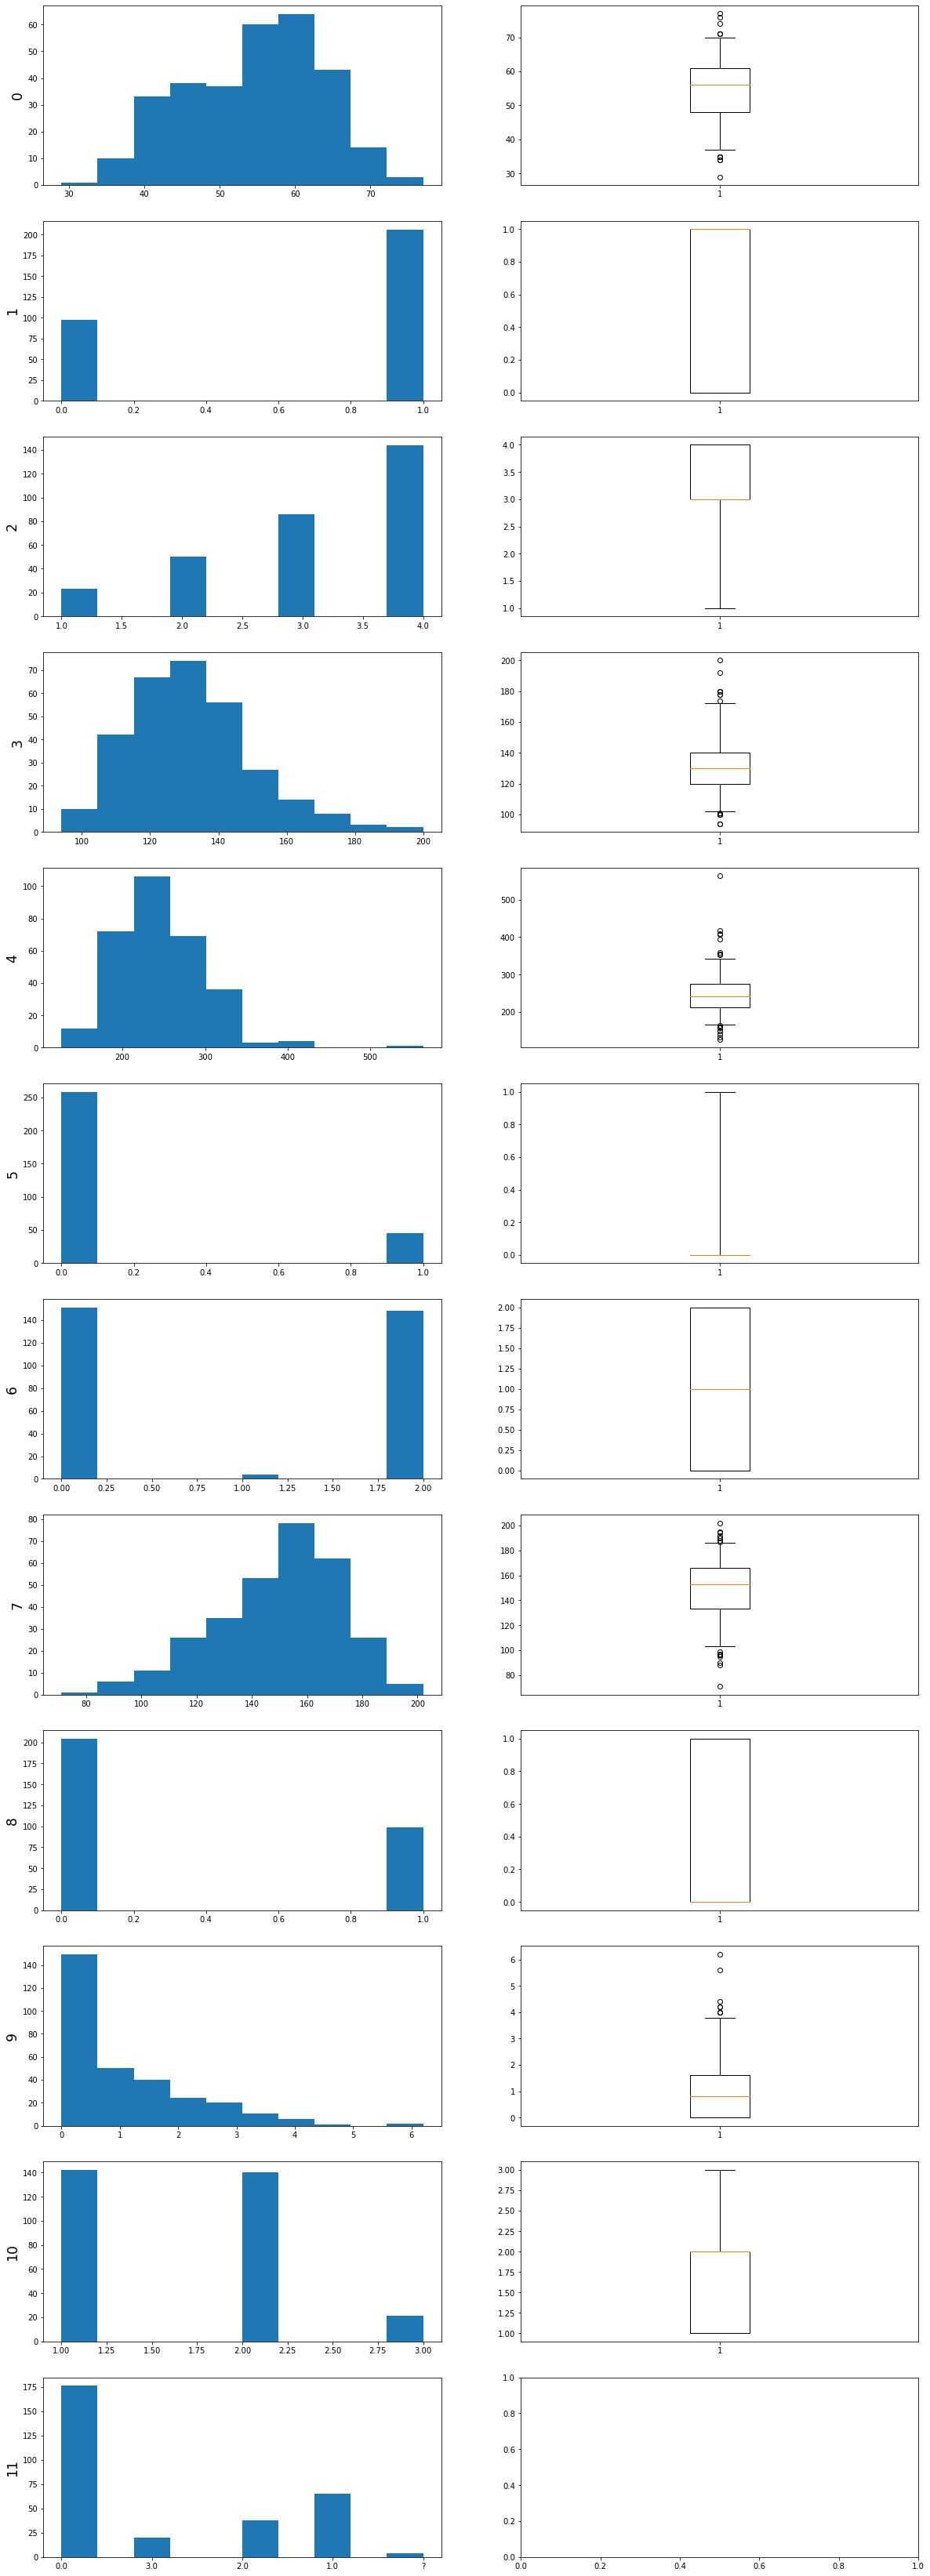

In [5]:
plot_hist_boxplot(df)

In [6]:
# Define the features and the outcome
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by `?`) with a `0`
X = X.replace(to_replace='?', value=0)

# Binarize `y` so that `1` means heart disease diagnosis and `0` means no diagnosis
y = np.where(y > 0, 0, 1)


# Scale the variables
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Defining the agglomerative clustering
#gmm_cluster = GaussianMixture(n_components=3, random_state=123)

# Fit model
#clusters = gmm_cluster.fit_predict(X_std)

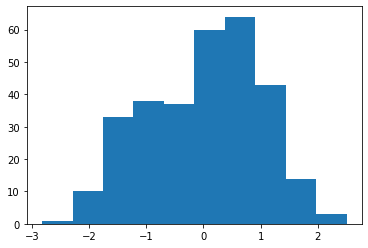

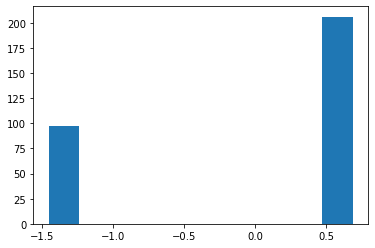

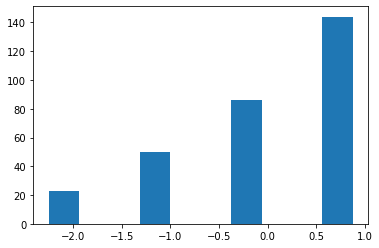

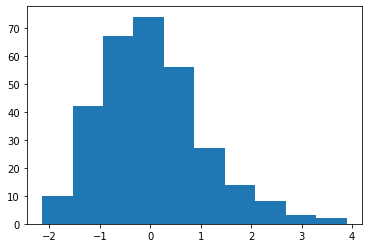

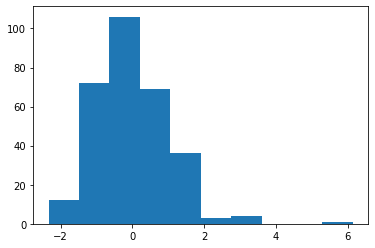

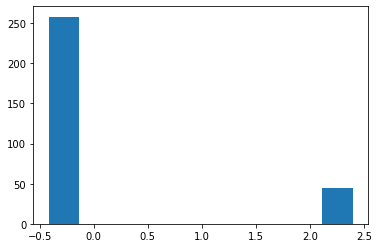

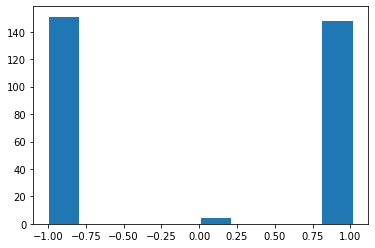

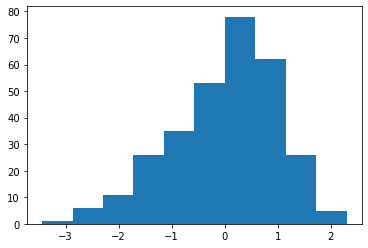

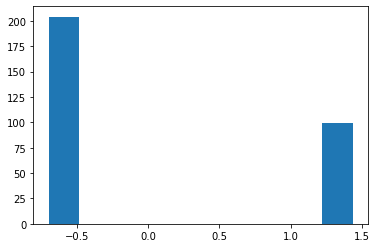

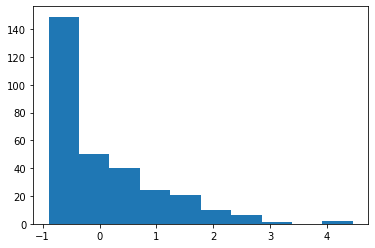

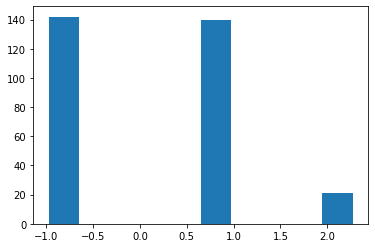

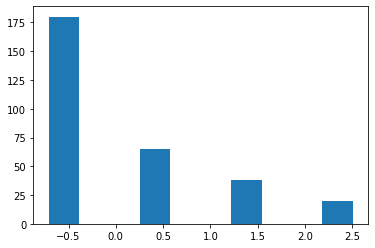

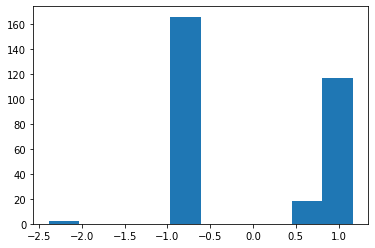

IndexError: index 13 is out of bounds for axis 1 with size 13

In [16]:
for i in range(len(X_std)-1):
    plt.hist(X_std[:, i])
    plt.show()

#### Apply GMM to the heart disease dataset by setting n_components=2. Get ARI and silhouette scores for your solution and compare it with those of the k-means and hierarchical clustering solutions that you implemented in the previous checkpoint assignments. Which algorithm performs best?

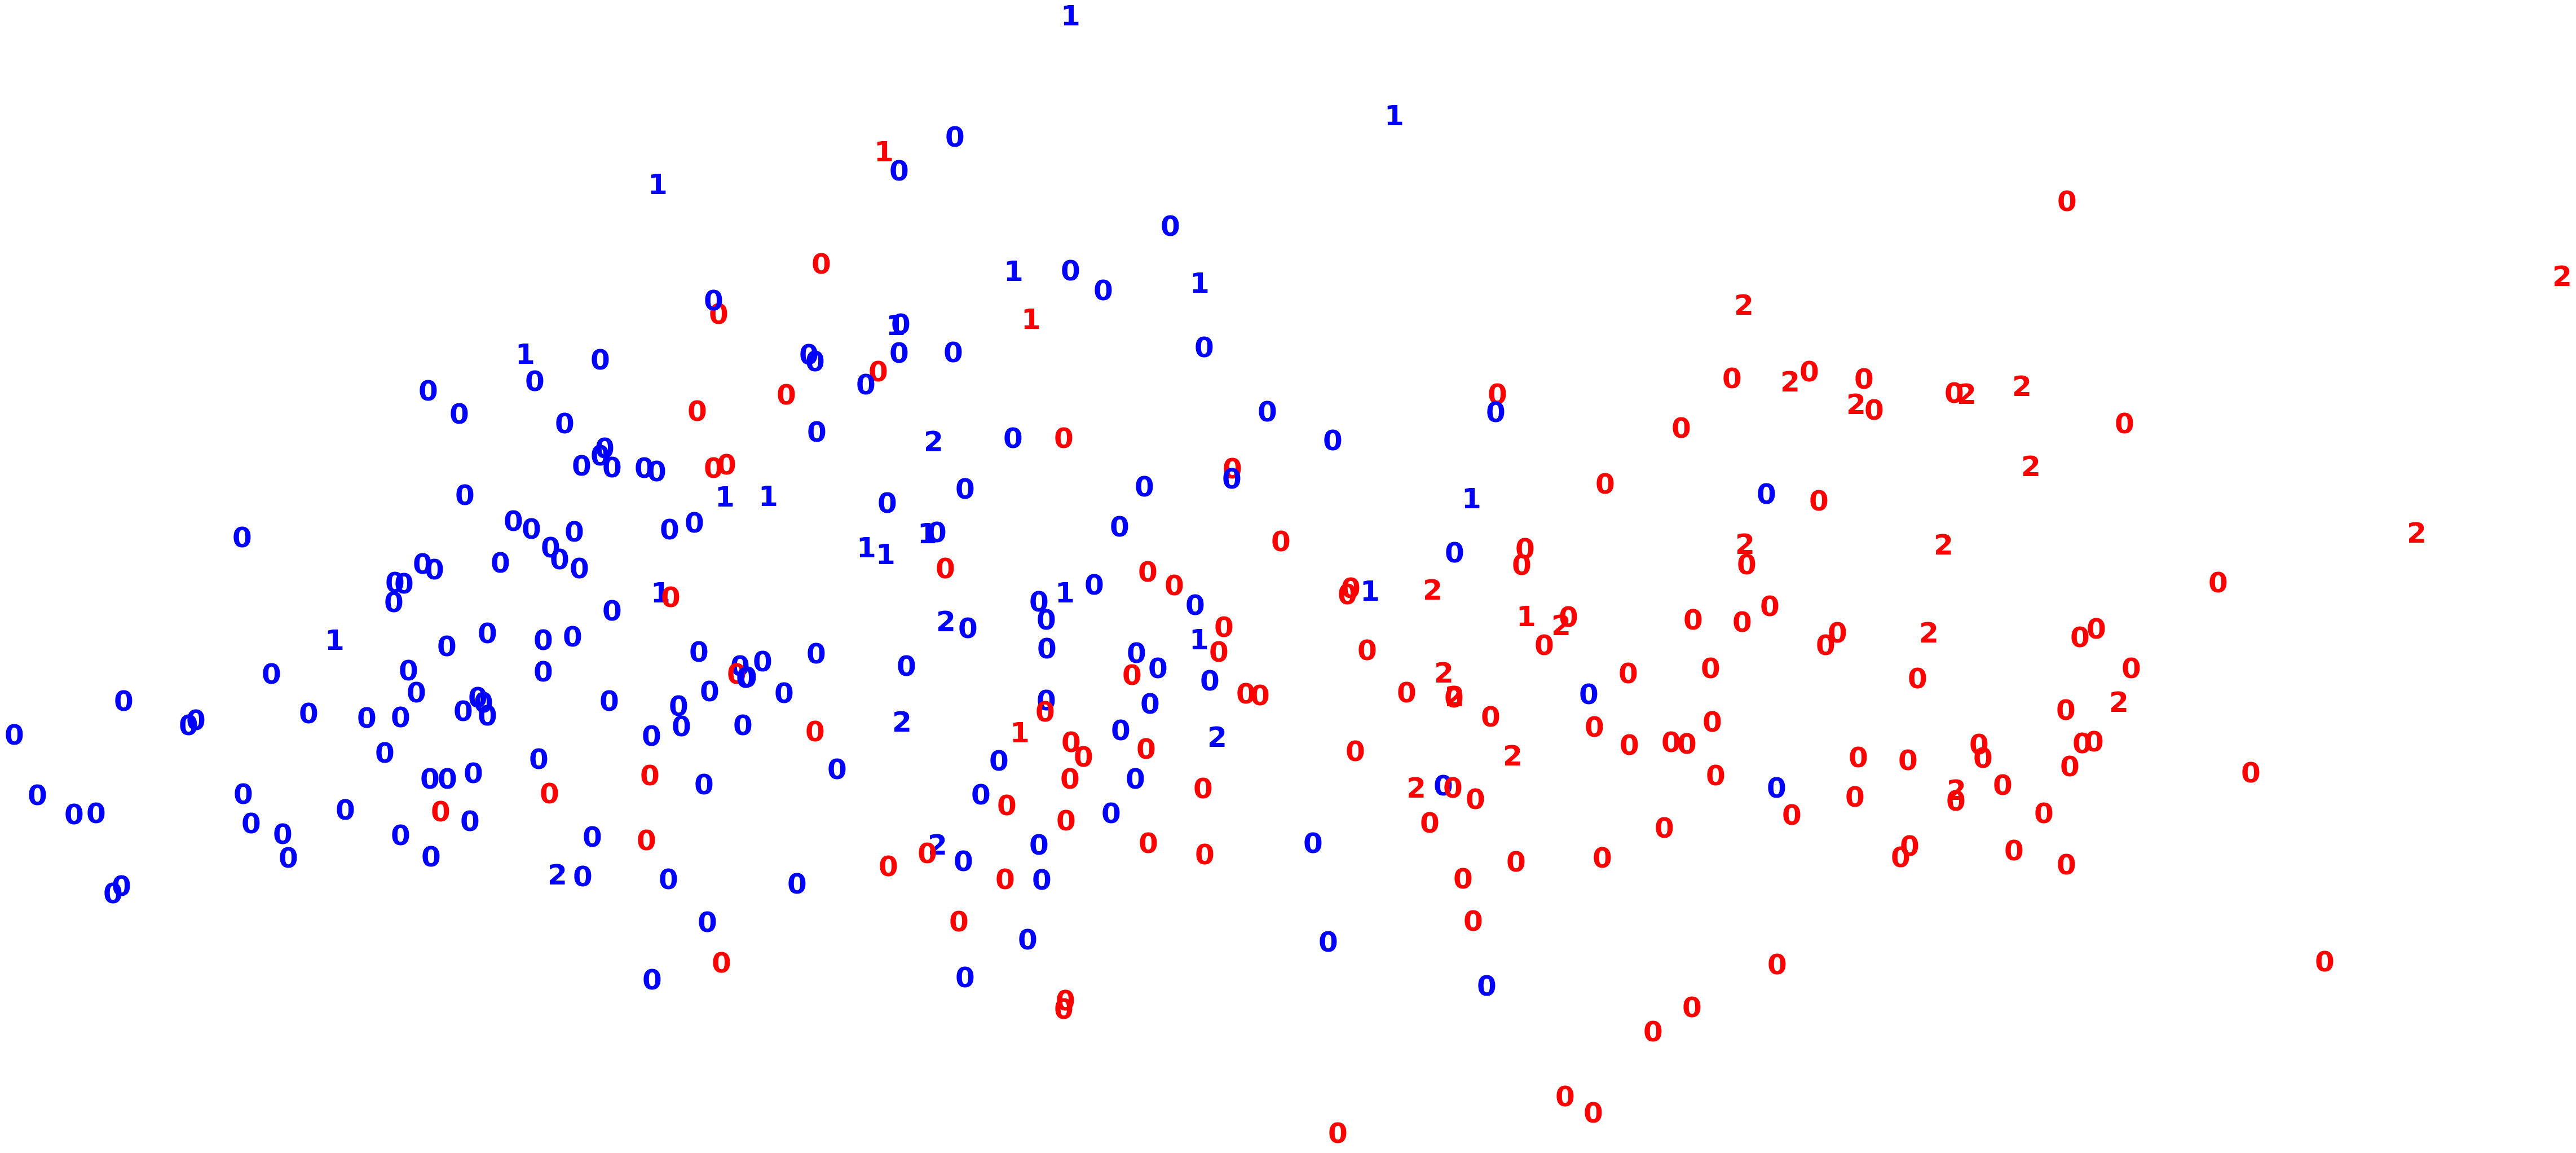

In [10]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [11]:
print("Adjusted Rand Index of the GMM solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the GMM solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the GMM solution: 0.00885605529793947
The silhoutte score of the GMM solution: 0.11998904728862914


The ARI is one of the lowest produced by any method. The silhouette score is also quite bad. Visually above we can see that this model does not reflect the ground truth very well.

#### GMM implementation of scikit-learn has a parameter called covariance_type. This parameter determines the type of covariance parameters to use. There are four types that you can specify:

- full: This is the default. Each component has its own general covariance matrix.
- tied: All components share the same general covariance matrix.
- diag: Each component has its own diagonal covariance matrix.
- spherical: Each component has its own single variance.


Try all of these. Which one performs best in terms of ARI and silhouette scores?

In [15]:
covs = ['full', 'tied', 'diag', 'spherical']

for cov in covs:
    # Defining the agglomerative clustering
    gmm_cluster = GaussianMixture(n_components=3, random_state=123, covariance_type=cov)

    # Fit model
    pred = gmm_cluster.fit_predict(X_std)
    
    sil = metrics.silhouette_score(X, pred, metric='euclidean')
    ari = metrics.adjusted_rand_score(y, pred)
    
    print(f'For Covariance {cov}', '\n', '--' *20)
    print(f'Adjusted Rand Index: {ari}', '\n')
    print(f'Silhouette Score: {sil}', '\n'*3)

For Covariance full 
 ----------------------------------------
Adjusted Rand Index: 0.00885605529793947 

Silhouette Score: 0.021314817117639443 



For Covariance tied 
 ----------------------------------------
Adjusted Rand Index: 0.10105413237718318 

Silhouette Score: -0.0060829837725358766 



For Covariance diag 
 ----------------------------------------
Adjusted Rand Index: 0.10413754422215428 

Silhouette Score: -0.007137140829824639 



For Covariance spherical 
 ----------------------------------------
Adjusted Rand Index: 0.2650655716734654 

Silhouette Score: 0.00071035925894231 





Spherical produces the best ARI while tied produces the best silhouette score. Still none of them are good.